In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# pip install ipython-autotime

In [3]:
%load_ext autotime

time: 0 ns (started: 2025-03-10 23:24:26 +03:00)


In [4]:
from modules.constants import TIMES

time: 16 ms (started: 2025-03-10 23:24:26 +03:00)


In [5]:
parameters_to_model = pd.read_csv('grid_search.csv')

time: 0 ns (started: 2025-03-10 23:24:26 +03:00)


Для наглядности, давайте работать с конкретной моделью, которая обучалась при 5 наблюдениях в тренировочной выборке

In [6]:
with open(f'models/52_model.pkl', 'rb') as f:
    cox = pickle.load(f)
df_train = pd.read_csv('Preprocessed/5_train_preprocessed.csv')

time: 1.83 s (started: 2025-03-10 23:24:26 +03:00)


Пока что посмотрим на один конкретный диск

In [7]:
df_one_disk = df_train[df_train['id'] == '45CHK11WFMYB']

time: 16 ms (started: 2025-03-10 23:24:28 +03:00)


In [8]:
pred = cox.predict(df_one_disk, times=TIMES) 
timeshift = (df_one_disk['time'] - df_one_disk['time'].shift(-1)).fillna(0)
timeshift = timeshift[::-1].cumsum()[::-1]

time: 31 ms (started: 2025-03-10 23:24:28 +03:00)


In [9]:
def plot_surv(predictions, timeshift=None):
    plt.figure(figsize=(10, 6))
    
    for index, row in predictions.iterrows():
        plt.plot(predictions.columns.astype(float) + (timeshift[index] if not timeshift is None else 0), row, label=f'Наблюдение № {index}')
    
    plt.xlabel('День')
    plt.ylabel('Вероятность выживания')
    plt.title('Функции выживания объектов')
    plt.legend()
    plt.grid(True)
    plt.show()

time: 16 ms (started: 2025-03-10 23:24:28 +03:00)


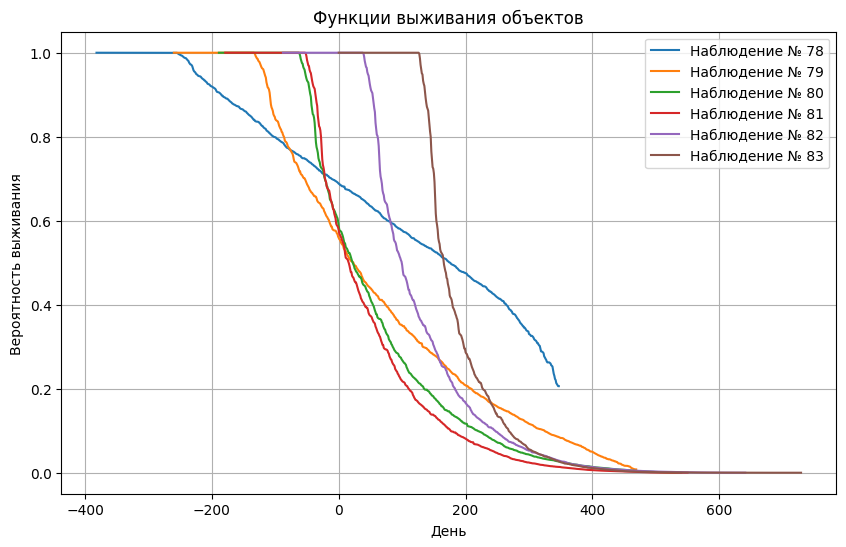

time: 344 ms (started: 2025-03-10 23:24:28 +03:00)


In [10]:
plot_surv(pred.drop(['id', 'time'], axis='columns'), timeshift)

Данный класс реализует два варианта агрегации наблюдений.
1. **n_dist_agg** \
Пусть цепочка состоит из 3 наблюдений, тогда итоговое значение функции выживания рассчитывается как:
$$S(t) = \frac{S_1(t) + wS_2(t) + w^2S_3(t)}{1 + w + w^2}$$
w - произвольный вес, меньший единицы \
$S_i(2)$ - функция выживания предсказанная по i-ому наблюдению, если считать, что наблюдения отсортированы по убыванию актуальности \

2. **t_dist_agg** \
   Первый метод не учитывает, насколько наблюдения устарели. Кажется логичным, чтобы наблюдения произошедшие 1 день назад давали больший вклад, нежели события, произошедшие месяц назад. В данном случае формула имеет следующий вид:
   $$S(t) = \frac{S_1(t) + e^{\frac{t_2 - t_1}{s}}S_2(t) + e^{\frac{t_3 - t_1}{s}}S_3(t)}{1 + e^{\frac{t_2 - t_1}{s}} +  e^{\frac{t_3 - t_1}{s}}}$$
   s - параметр масштаба, чем он меньше, тем больше модель "чувствует" разницу во времени \
   $t_i$ - момент времени, в который былы предсказана функция выживания. Чем меньше, тем предсказание старее.

3. **geom_agg**
    $$S(t) = \alpha S(t, 0) + (1-\alpha)S_{agg}(t, -1) = \alpha S(t, 0) + \alpha (1-\alpha)S(t,-1) + \alpha (1-\alpha)^2S(t,-2) + ...
= \alpha (S(t, 0) + (1-\alpha)S(t,-1) + (1-\alpha)^2S(t,-2) + ... + (1-\alpha)^{n-1}S(t, -(n-1))) + (1-\alpha)^nS(t, -n)$$ \
АХТУНГ! Кажется геометрическая агрегация сломалась, после того как я добавил pred_corrected

In [13]:
# cox = CoxTimeVaryingEstimator(penalizer=0.1, l1_ratio=0.1)
# cox.fit(df_train)

time: 0 ns (started: 2025-03-10 23:24:28 +03:00)


In [72]:

pred_agg = PredictionsAggregator(cox, mode='last')
# X = pred_agg.predict(df_train, times=TIMES)
# X = pred_agg.predict(df_train[df_train['id'].isin(['Z3004NAP', 'JK11A8B9J9L2AF'])].reset_index(), times=None)


time: 0 ns (started: 2025-03-11 10:54:39 +03:00)


In [74]:
X_selected_disk = df_train[df_train['id'] == '45CHK11WFMYB'].reset_index(drop=True)
# pred = cox_new.predict(X_selected_disk, times=TIMES).drop(['id', 'time'], axis='columns')

time: 16 ms (started: 2025-03-11 10:54:46 +03:00)


In [75]:
def plot_results(model, X, disk_id, mode='n_dist', times=None, shift_observ=True):

    X_selected_disk = X[X['id'] == disk_id].reset_index(drop=True)

    pred = model.predict(X_selected_disk, times=times).drop(['id', 'time', 'event'], axis='columns')
    
    timeshift = (X_selected_disk['time'] - X_selected_disk['time'].shift(-1)).fillna(0)
    timeshift = timeshift[::-1].cumsum()[::-1].reset_index(drop='True')

    pred_agg = PredictionsAggregator(model, mode=mode)
    X_agg = pred_agg.predict(X_selected_disk.reset_index(drop='True'), times=times)
    
    plt.figure(figsize=(10, 6))
    for index, row in pred.iterrows():
        try:
            plt.plot(pred.columns.astype(float) + (timeshift[index] if shift_observ else 0), row, label=f'Наблюдение № {index}')
        except:
            pass

    X_agg = X_agg.drop(['id', 'time'], axis='columns')
    plt.plot(X_agg.columns.astype(float), X_agg.values.reshape(-1), linestyle='dashed' ,label=f'Агрегат')

    plt.xlabel('День')
    plt.ylabel('Вероятность выживания')
    plt.title(f'Функции выживания объектов, mode={mode}')
    plt.legend()
    plt.grid(True)
    plt.show()

time: 16 ms (started: 2025-03-11 10:54:47 +03:00)


In [85]:
def plot_results(model, X, disk_id, mode='n_dist', times=None, shift_observ=True):

    X_selected_disk = X[X['id'] == disk_id].reset_index(drop=True)

    pred = model.predict(X_selected_disk, times=times).drop(['id', 'time'], axis='columns')
    
    timeshift = (X_selected_disk['time'] - X_selected_disk['time'].shift(-1)).fillna(0)
    timeshift = timeshift[::-1].cumsum()[::-1].reset_index(drop='True')

    pred_agg = PredictionsAggregator(model, mode=mode)
    X_agg = pred_agg.predict(X_selected_disk.reset_index(drop='True'), times=times)
    
    plt.figure(figsize=(10, 6))
    for index, row in pred.iterrows():
        try:
            plt.plot(pred.columns.astype(float) + (timeshift[index] if shift_observ else 0), row, label=f'Наблюдение № {index}')
        except:
            pass

    X_agg = X_agg.drop(['id', 'time'], axis='columns')
    # plt.plot(X_agg.columns.astype(float), X_agg.values.reshape(-1), linestyle='dashed' ,label=f'Агрегат')

    plt.xlabel('День')
    plt.ylabel('Вероятность выживания')
    plt.title(f'Функции выживания объектов')
    plt.legend()
    plt.grid(True)
    plt.show()

time: 0 ns (started: 2025-03-11 10:55:23 +03:00)


In [86]:
# df_train_selected = df_train[df_train['id'].isin(['0F112CC45', '13H2B97AS', '45CHK11WFMYB'])]

time: 0 ns (started: 2025-03-11 10:55:24 +03:00)


In [87]:
baseline_cum_hazard = cox.baseline_cumulative_hazard_ ** 1
times = baseline_cum_hazard.index.values
cumulative_hazard = baseline_cum_hazard.values.flatten()
instantaneous_hazard = np.diff(cumulative_hazard, prepend=0)

time: 0 ns (started: 2025-03-11 10:55:24 +03:00)


Text(0, 0.5, 'Риск')

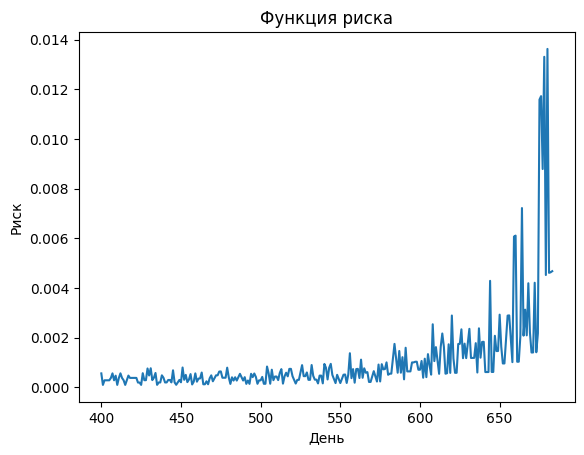

time: 125 ms (started: 2025-03-11 10:55:25 +03:00)


In [88]:
START_DAY = 400
x = np.arange(len(instantaneous_hazard[START_DAY:])) + START_DAY
plt.plot(x,instantaneous_hazard[START_DAY:])
plt.title('Функция риска')
plt.xlabel('День')
plt.ylabel('Риск')

In [89]:
df_train[df_train['id'] == '45CHK11WFMYB'].iloc[:,:10]

,time,id,capacity_bytes,event,smart_1_raw,smart_3_raw,smart_4_raw,smart_9_raw,smart_12_raw,smart_183_raw
78,0,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.586993,-0.608813,-0.010971
79,122,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.394519,-0.608813,-0.010971
80,193,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.282429,-0.608813,-0.010971
81,203,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.266642,-0.608813,-0.010971
82,294,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.123043,-0.608813,-0.010971
83,382,45CHK11WFMYB,0.727777,1,-0.449779,3.191285,-0.118562,-0.984049,-0.608813,-0.010971


time: 15 ms (started: 2025-03-11 10:55:25 +03:00)


In [90]:
SHIFT_FLAG = False
MODE = 'last'
df_train_last = df_train[df_train['time'] != df_train.groupby('id')['time'].transform('max')]

time: 31 ms (started: 2025-03-11 10:55:26 +03:00)


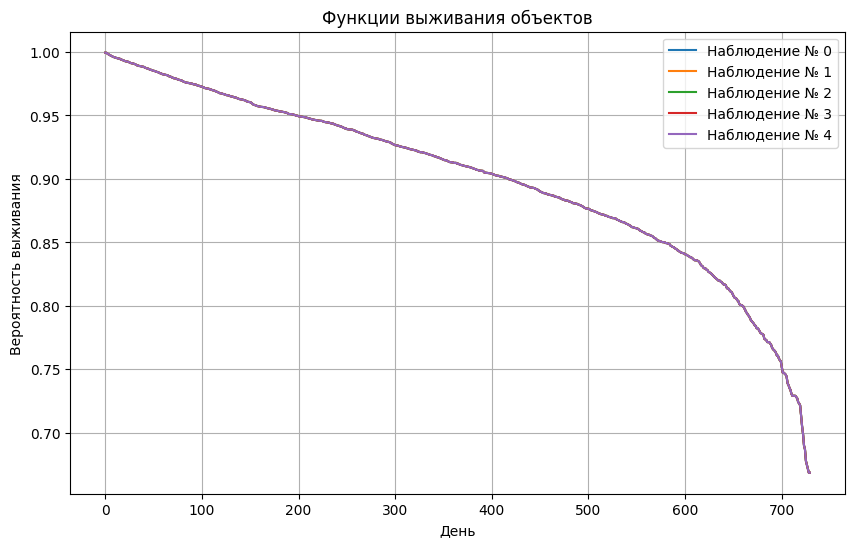

time: 172 ms (started: 2025-03-11 10:55:26 +03:00)


In [91]:
plot_results(cox, df_train_last, '45CHK11WFMYB', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

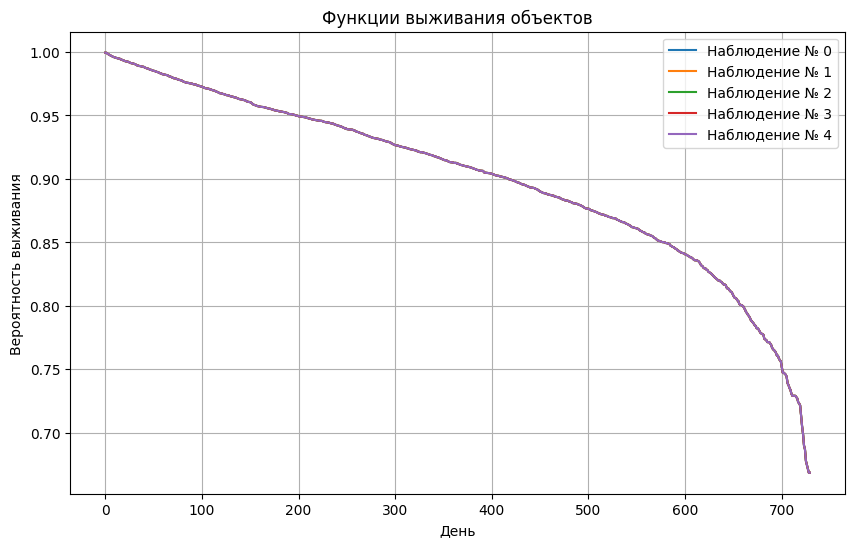

time: 172 ms (started: 2025-03-11 10:55:27 +03:00)


In [92]:
plot_results(cox, df_train_last, '45CHK11WFMYB', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

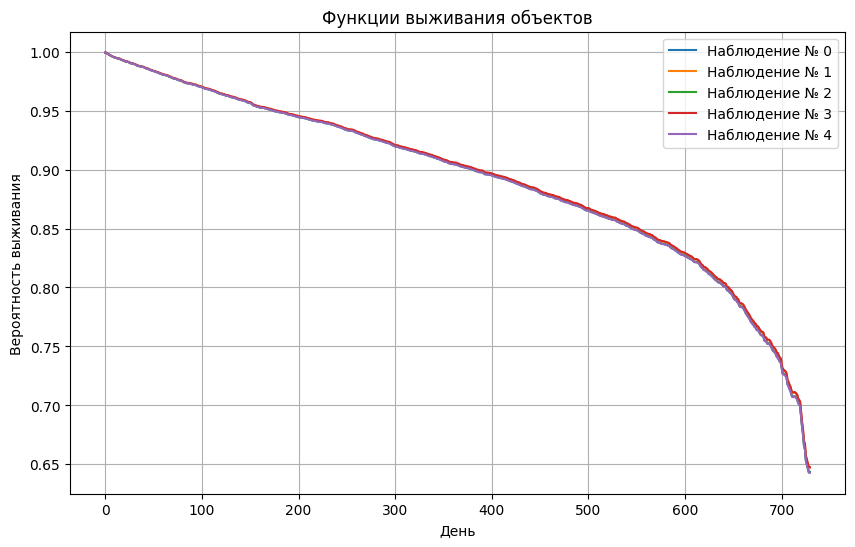

time: 172 ms (started: 2025-03-11 10:55:28 +03:00)


In [93]:
plot_results(cox, df_train_last, '0F112CC45', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

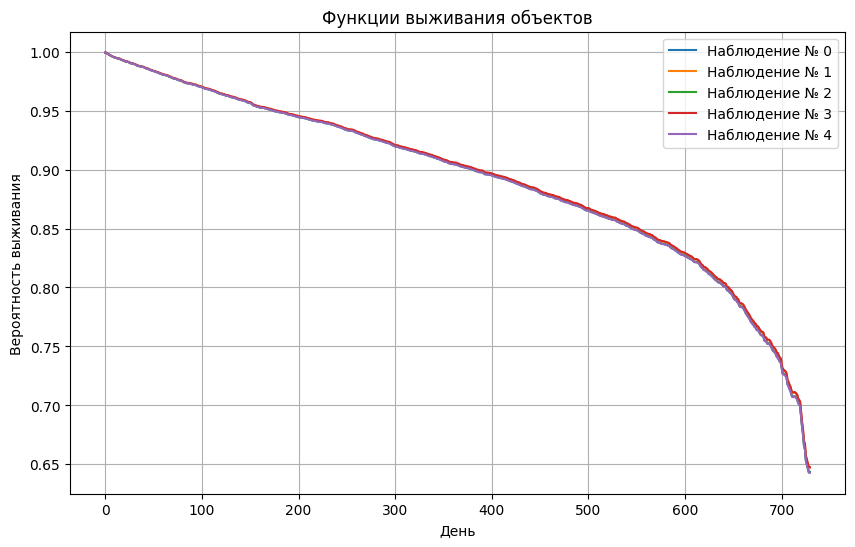

time: 172 ms (started: 2025-03-11 10:55:29 +03:00)


In [94]:
plot_results(cox, df_train_last, '0F112CC45', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

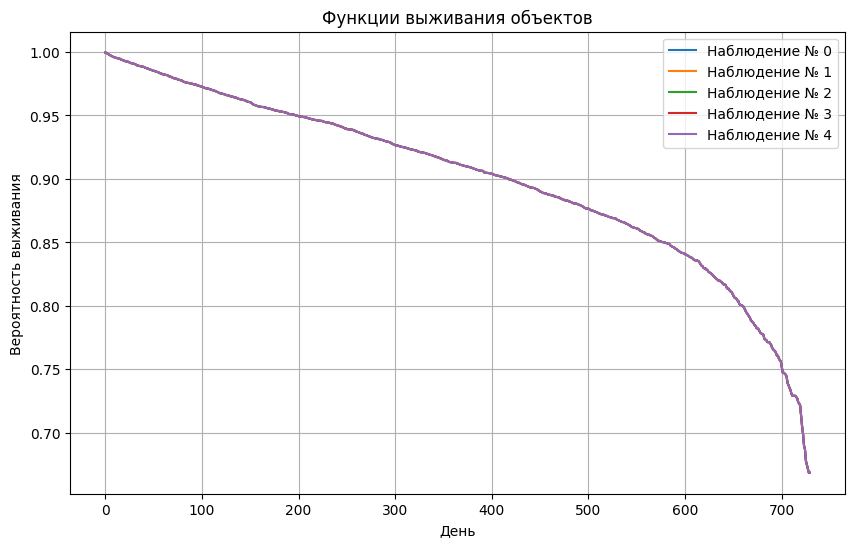

time: 172 ms (started: 2025-03-11 10:55:30 +03:00)


In [95]:
plot_results(cox, df_train_last, '13H2B97AS', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

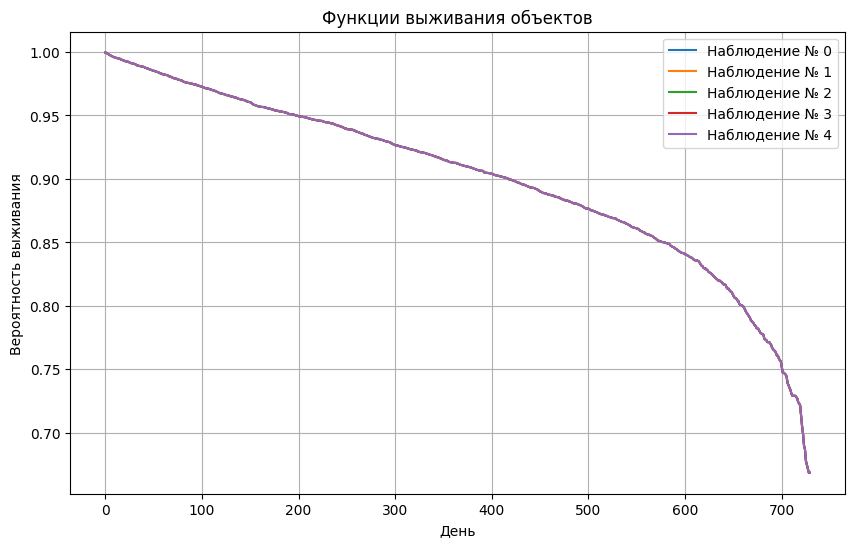

time: 172 ms (started: 2025-03-11 10:55:31 +03:00)


In [96]:
plot_results(cox, df_train_last, '13H2B97AS', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

# Точечные оценки

In [21]:
from lifelines import CoxTimeVaryingFitter
from modules.model import CoxTimeVaryingEstimator, PredictionsAggregator
from modules.constants import TIMES
from modules.metrics import ibs_remain
from modules.metrics_TV import get_ci_and_ibs
from lifelines.utils import concordance_index
import pandas as pd

time: 16 ms (started: 2025-03-10 23:31:33 +03:00)


In [54]:
TRAIN_SAMPLES = 20
df_train_n = pd.read_csv(f'Preprocessed/{TRAIN_SAMPLES}_train_preprocessed.csv')

df_test_1 = pd.read_csv(f'Preprocessed/{TRAIN_SAMPLES}_1_test_preprocessed.csv')
df_test_25 = pd.read_csv(f'Preprocessed/{TRAIN_SAMPLES}_25_test_preprocessed.csv')

grid_search = pd.read_csv('grid_search.csv')
model_id = grid_search[grid_search['train_samples'] == TRAIN_SAMPLES].sample(1, random_state=42)['model_id'].unique()[0]

time: 2.88 s (started: 2025-03-10 23:51:19 +03:00)


In [44]:
with open(f'models/{model_id}_model.pkl', 'rb') as f:
    cox = pickle.load(f)

time: 656 ms (started: 2025-03-10 23:35:06 +03:00)


In [45]:
df_train_n = df_train_n.sort_values(by=['id', 'time'], ascending=False)
X_last_sample = df_train_n.groupby('id').head(2)

time: 281 ms (started: 2025-03-10 23:35:07 +03:00)


In [46]:
X_last_sample = X_last_sample.sort_values(by=['id', 'time']) 
df_train_n = df_train_n.sort_values(by=['id', 'time']) 


time: 156 ms (started: 2025-03-10 23:35:07 +03:00)


Интересные получились результаты. Как будто именно когда происходит агрегация, есть ошибка.

In [47]:
get_ci_and_ibs(cox, X_last_sample, TIMES, 'agg')

(0.8197460658503011, 0.7301635292715631)

time: 1.83 s (started: 2025-03-10 23:35:07 +03:00)


In [69]:
pred_agg_last = PredictionsAggregator(cox, mode='last')
get_ci_and_ibs(pred_agg_last, df_test_25, TIMES, 'agg')

(0.8218412931921227, 0.7460604727216347)

time: 5.98 s (started: 2025-03-11 10:53:33 +03:00)


In [70]:
pred_agg_last = PredictionsAggregator(cox, mode='first')
get_ci_and_ibs(pred_agg_last, df_test_25, TIMES, 'agg')

(0.30226839853374887, 0.6669964787909994)

time: 6.05 s (started: 2025-03-11 10:53:39 +03:00)


In [49]:
pred_agg_last = PredictionsAggregator(cox, mode='last')
get_ci_and_ibs(pred_agg_last, X_last_sample, TIMES, 'agg')

(0.8197460658503011, 0.7309504781246591)

time: 2.08 s (started: 2025-03-10 23:35:40 +03:00)


In [50]:
pred_agg_last = PredictionsAggregator(cox, mode='prob_dist')
get_ci_and_ibs(pred_agg_last, X_last_sample, TIMES, 'agg')

(0.8197460658503011, 0.7309504781246591)

time: 3.58 s (started: 2025-03-10 23:35:42 +03:00)


In [ ]:
def prepare_data_for_test(df, id_col='id', time_col='time', event_col='event', mode = 'independent'):
    '''
    На вход принимает датасет вида id_col, time_col, event_col, признаки
    На выходе датафрейм, events, durations
    У датафрейма отсечены самые последние наблюдения соответствующие каждому диску
    '''
    durations = df.groupby(id_col)[time_col].transform('max') - df[time_col]
    events = df.groupby(id_col)[event_col].transform('max')[durations != 0]
    result_df = df.loc[durations != 0, :]
    durations = durations[durations != 0]
    if mode=='agg':
        last_observ = result_df[time_col] == result_df.groupby(id_col)[time_col].transform('max')
        events = events[last_observ]
        durations = durations[last_observ]
    return result_df, events.astype('bool'), durations

In [ ]:
X_test, test_events, test_durations = prepare_data_for_test(df_train_n, mode = 'agg')
survival_test = pd.DataFrame()
survival_test['event'] = test_events
survival_test['duration'] = test_durations

X_pred = pred_agg_last.predict(X_test, TIMES)

survival_estim = X_pred.drop([pred_agg_last.id_col, pred_agg_last.time_col], axis='columns')
ibs = ibs_remain(
    None, 
    survival_test.to_records(index=False),  
    survival_estim, 
    TIMES 
)
print(ibs)

In [ ]:
my_durations = df_train_n.groupby('id')['time'].transform('max') - df_train_n['time']
my_events = df_train_n.groupby('id')['event'].transform('max')[my_durations != 0]
df_x = df_train_n.loc[my_durations != 0]
my_durations = my_durations[my_durations != 0]
my_durations = my_durations[df_x['time'] == df_x.groupby('id')['time'].transform('max')]
my_events = my_events[df_x['time'] == df_x.groupby('id')['time'].transform('max')].astype('bool')

In [ ]:
(survival_test['duration'] == my_durations).all(), (survival_test['event'] == my_events).all(), (df_x == X_test).all().all()

In [ ]:
my_estim = pred_agg_last.predict(df_x, TIMES).drop(['time', 'id'], axis = 'columns')

my_survival_test = pd.DataFrame()
my_survival_test['event'] = my_events
my_survival_test['duration'] = my_durations

In [ ]:
ibs = ibs_remain(
    None, 
    my_survival_test.to_records(index=False),  
    my_estim, 
    TIMES 
)
ibs

In [ ]:
last_durations = X_last_sample.groupby('id')['time'].transform('max') - X_last_sample['time']
last_events = X_last_sample.groupby('id')['event'].transform('max')[last_durations != 0]
df_lastx = X_last_sample.loc[last_durations != 0]
last_durations = last_durations[last_durations != 0]
last_durations = last_durations[df_lastx['time'] == df_lastx.groupby('id')['time'].transform('max')]
last_events = last_events[df_lastx['time'] == df_lastx.groupby('id')['time'].transform('max')].astype('bool')

In [ ]:
last_durations, my_durations

Эксперимент показывает, что ошибка должно быть кроется в predict. Мне так кажется.

# Не используется 

In [ ]:
def create_start_stop(df):
    df['start'] = df['time'] - df.groupby('id')['time'].transform('min')
    df['stop'] = df.groupby('id')['start'].shift(-1)
    df['event'] = df.groupby('id')['event'].shift(-1)
    return df.dropna(subset=["stop"])

In [ ]:
cox = CoxTimeVaryingFitter(l1_ratio = 0.5, penalizer=0.5)
df_train_start_stop = create_start_stop(df_train_n)
cox.fit(df_train_start_stop, id_col='id', event_col='event')

In [ ]:
cox.predict(df_train_start_stop)

In [ ]:
def get_usual_cox_ibs(cox, X):

    survival_test = pd.DataFrame()
    durations = X.groupby('id')['time'].transform('max') - X['time']
    events = X['events'].groupby('id')['event'].transform('max')[durations != 0]
    X_test = X.loc[durations != 0:]
    durations = durations[durations != 0]
    survival_test['event'] = test_events
    survival_test['duration'] = test_durations

    # Если параметр times не передаётся явно, то интегрируем по всему временному интервалу
    if times is None:
        times = np.array(model.baseline_survival_.index) 

    survival_estim = cox.predict(X_test).drop([model.id_col, model.time_col], axis='columns')
    
    ibs = ibs_remain(
        None,
        survival_test.to_records(index=False),  
        survival_estim, 
        times 
    )
    return ibs